In [1]:
import pandas as pd
import seaborn as sns
import jsonlines

In [2]:
import os

def find_files_with_extension(_dir, ext):
    for root, dirs, files in os.walk(_dir):
        for file in files:
            if file.endswith(ext):
                yield os.path.join(root, file)

def load_jsonlines(filename):
    with jsonlines.open(filename) as r:
        for obj in r:
            yield obj

def jsonl_dir_as_df(_dir):
    files_g = find_files_with_extension(_dir, ".jsonl")
    df = pd.DataFrame.from_records(
        l for fn in files_g for l in load_jsonlines(fn)
    )
    return df

In [3]:
def add_rolling_mean(df, columns, window, groupby, sortby):
    rolling = df.sort_values(sortby)[columns].groupby(df['mode']).rolling(window=window).mean()
    rolling.index = rolling.index.droplevel(level=0)
    rolling_columns = [f'{c}_rolling' for c in columns]
    df[rolling_columns] = rolling
    return df

In [4]:
df = jsonl_dir_as_df('..')

In [5]:
dfs = df[df['label.batch'] == 'dev_tabular']

In [6]:
dfd = dfs[dfs['done']]

In [7]:
pd.__version__


'1.0.5'

In [28]:
dfi = pd.DataFrame(
    dfs['episode_rewards'].tolist(), 
    index=pd.MultiIndex.from_frame(dfs[['episode', 'mode']])
)
dfi.columns.name = 'agent_idx'
dfi = dfi.stack()
dfi.name = 'individual_reward'
dfi = dfi.to_frame().reset_index()
dfi = add_rolling_mean(dfi, ['individual_reward'], 1000 , ['mode', 'agent_idx'], 'episode')

In [12]:
dfd = add_rolling_mean(dfd, ['avg_episode_rewards', 'episode_step'], 100 , 'mode', 'episode')

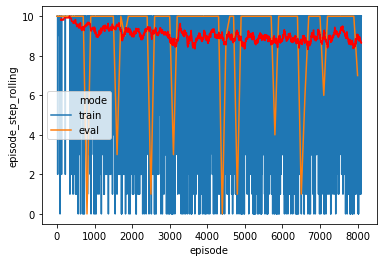

In [13]:
sns.lineplot(data=dfd, x='episode', y='episode_step', hue='mode')
sns.lineplot(data=dfd[dfd['mode'] == 'train'], x='episode', y='episode_step_rolling', color='red')

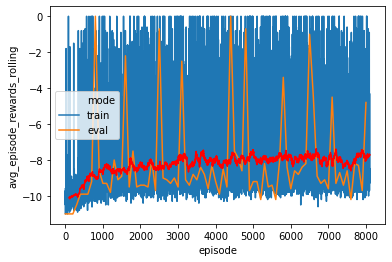

In [14]:
sns.lineplot(data=dfd, x='episode', y='avg_episode_rewards', hue='mode')
sns.lineplot(data=dfd[dfd['mode'] == 'train'], x='episode', y='avg_episode_rewards_rolling', color='red')

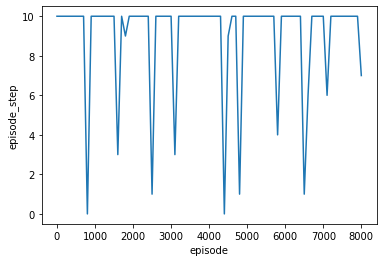

In [15]:
sns.lineplot(data=dfd[dfd['mode'] == 'eval'], x='episode', y='episode_step')

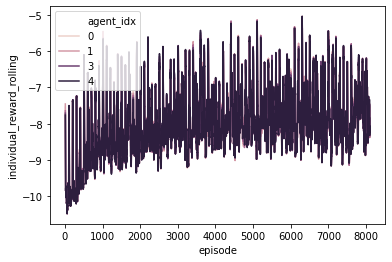

In [29]:
sns.lineplot(data=dfi[dfi['mode'] == 'train'], x='episode', y='individual_reward_rolling', hue='agent_idx', n_boot=1)